# Performance test for the Ag3 site filter dt_20200416 

This notebook tests the performance of the Ag3 site fiter named dt_20200416, for all sites (including chromosome X) in the release, except for sites that were used to train the model. Only the site filter for the `gamb_colu` species group is tested (not `arab` or `gamb_colu_arab`) because all of our ground truths are from `gamb_colu` crosses. This model's output has already been released as `filter_pass` for each site, which is the site filter that will be tested.

Note: `training_negative` and `training_positive`, which indicate whether a site was used in training and its ground truth class, are not included in the release for chromosome X, because chromosome X was not used to train the Ag3 model.

### Ground truths
The Mendelian error data, i.e. `mendel_error` and `n_samples_called`, for all cross families (available in the same data release) are used as indepedent ground truths for all autosomal sites. The male heterozygosity data, i.e. `n_male_het` and `all_males_called`, for all cross families are used as independent ground truths for chromosome X.

Sets of cross families can be grouped according to their historical use, with some overlap:
1. Those used to train the released Ag3 site filter model, i.e. dt_20200416, namely {18-5, 29-2, 36-9, 42-4, 46-9, 47-6, 78-2, 80-2, K2, K4}
2. Those used to determine the Phase 2 accessibility map, namely {B5, K2, K4, K6}
3. Those not used in training nor in Phase 2, namely {37-3, 45-1, 73-2}.

### Comparisons
This notebook also compares the performance of the Ag3 site filter against:
1. No filter, i.e. passing everything
2. The site accessibility filter released in Phase 2.

### Metrics
These are the metrics calculated and reported on for each ground truth (cross family), for each chromosome arm:
1. Prevalence (P), i.e. the fraction of sites passed in the ground truth
2. Predicted Prevalance (PP), i.e. the fraction of sites passed by the filter
3. True Positive Rate (TPR)
4. False Positive Rate (FPR)
5. True Negative Rate (TNR), i.e. 1 - FPR
6. False Negative Rate (FNR),  i.e. 1 - TPR
7. False Discovery Rate (FDR)
8. Youden's J statistic (J), i.e. TPR + TNR - 1




## Settings

In [1]:
autosome_chrom_arms = {'2L', '2R', '3L', '3R'}
allosome_chrom_arms = {'X'}
autosome_crosses_stat_fields = {'mendel_error', 'n_samples_called'}
allosome_crosses_stat_fields = {'n_male_het', 'all_males_called'}
cross_family_ids = {'18-5', '29-2', '36-9', '37-3', '42-4', '45-1', '46-9', '47-6', '73-2', '78-2', '80-2', 'B5', 'K2', 'K4', 'K6'}

In [2]:
# Imports
import ag3
import ag2
import dask.array as da
import numpy as np
import pandas as pd
#
import numba
from numba import types
from numba.typed import Dict

In [3]:
# Data APIs
ag3_release_data = ag3.release_data()
ag2_release_data = ag2.release_data()

## Get the Ag3 site filter data using the accompanying `ag3` module

In [4]:
%%time
ag3_site_filters = {}
for chrom_arm in autosome_chrom_arms | allosome_chrom_arms:
    ag3_site_filters[chrom_arm] = ag3_release_data.load_mask(chrom_arm, mask_id='gamb_colu')
# Normally takes a few seconds

CPU times: user 296 ms, sys: 20.6 ms, total: 316 ms
Wall time: 3.23 s


In [5]:
# Eyeball one of the Dask arrays
ag3_site_filters['2L']

,Array,Chunk
Bytes,48.53 MB,300.00 kB
Shape,"(48525747,)","(300000,)"
Count,163 Tasks,162 Chunks
Type,bool,numpy.ndarray


## Get the Ag2 site filter data using the accompanying `ag2` module

In [6]:
%%time
ag2_site_filters = {}
for chrom_arm in autosome_chrom_arms | allosome_chrom_arms:
    # Note there are not site filters for multiple species groups in the Ag2 release
    is_accessible = ag2_release_data.load_is_accessible(chrom_arm)
    filter_n = ag2_release_data.load_filter_n(chrom_arm)
    ag2_site_filters[chrom_arm] = da.compress(~filter_n, is_accessible, axis=0)
    # Computing chunk sizes can take about 20 seconds per chrom_arm
    ag2_site_filters[chrom_arm].compute_chunk_sizes()
# Give it a few minutes

CPU times: user 45.3 s, sys: 4.59 s, total: 49.9 s
Wall time: 2min 37s


In [7]:
# Eyeball one of the Dask arrays
ag2_site_filters['2L']

,Array,Chunk
Bytes,48.53 MB,48.21 kB
Shape,"(48525747,)","(48208,)"
Count,5122 Tasks,1024 Chunks
Type,bool,numpy.ndarray


## Get the Ag3 crosses stats and calculate the ground truths

In [8]:
# Define functions that compute the ground truth from the crosses stats
# Note that these shouldn't need to be delayed functions, which would require repeated compute()
def calc_autosome_ground_truth(crosses_stats):
    mendel_error = crosses_stats['mendel_error']
    n_samples_called = crosses_stats['n_samples_called']
    
    # Where a site has mendel_error > 0, then return 0, i.e. bad site
    # Otherwise, where a site has 0 mendel_error,
    #   and the site has the max number of samples called (of all sites in the chromosome, i.e. n_samples_called.shape[0]),
    #   then return 1, i.e. good site
    # Otherwise, where a site has no mendel_error,
    #   and the site does not have the max number of samples called, 
    #   then return -1, i.e. undetermined site.
    
    return da.where(mendel_error > 0, 0, da.where(n_samples_called == da.max(n_samples_called), 1, -1))

def calc_allosome_ground_truth(crosses_stats):
    n_male_het = crosses_stats["n_male_het"]
    all_males_called = crosses_stats["all_males_called"]
    
    # Where a site has n_male_het > 0, then return 0, i.e. bad site
    # Otherwise, where a site has 0 n_male_het,
    #   and the site has all_males_called
    #   then return 1, i.e. good site
    # Otherwise, where a site has 0 n_male_het,
    #   and the site does not have all_males_called
    #   then return -1, i.e. undetermined site
    
    return da.where(n_male_het > 0, 0, da.where(all_males_called, 1, -1))

In [9]:
# Get the specified crosses stats, for the specified chromosome arms, for all cross families
def get_crosses_stats(chrom_arms, crosses_stat_fields):
    crosses_stats = {}
    
    for chrom_arm in chrom_arms:
        crosses_stats[chrom_arm] = {}
        
        for cross_id in cross_family_ids:
            crosses_stats[chrom_arm][cross_id] = {}
            
            for field in crosses_stat_fields:
                crosses_stats[chrom_arm][cross_id][field] = ag3_release_data.load_crosses(chrom_arm, cross_id, field)
            
            if chrom_arm in autosome_chrom_arms:
                # This function call shouldn't need to be delayed
                crosses_stats[chrom_arm][cross_id]['ground_truth'] = calc_autosome_ground_truth(crosses_stats[chrom_arm][cross_id])
            elif chrom_arm in allosome_chrom_arms:
                # This function call shouldn't need to be delayed
                crosses_stats[chrom_arm][cross_id]['ground_truth'] = calc_allosome_ground_truth(crosses_stats[chrom_arm][cross_id])
    return crosses_stats

#### For the autosomes

In [10]:
%%time
autosome_crosses_stats = get_crosses_stats(autosome_chrom_arms, autosome_crosses_stat_fields)
# Should take < 30 secs

CPU times: user 4.05 s, sys: 146 ms, total: 4.2 s
Wall time: 26.6 s


In [11]:
%%time
# Eyeball some of the crosses stats
example_stat1 = autosome_crosses_stats['2L']['18-5']['mendel_error'].compute()
example_stat2 = autosome_crosses_stats['2L']['18-5']['n_samples_called'].compute()
print(example_stat1[0:2])
print(example_stat2[0:2])
# Should take < 10 secs

[0 0]
[0 0]
CPU times: user 1.97 s, sys: 898 ms, total: 2.87 s
Wall time: 1.87 s


In [12]:
%%time
# Eyeball some of the ground truth values
# Note: this takes two computes: first to go from a lazy Dask array (from a Zarr array) to a concrete value
#   second to run the delayed function on those concrete values
example_ground_truths = autosome_crosses_stats['2L']['18-5']['ground_truth'].compute()
example_ground_truths[0:2]
# Should take < 10 secs

CPU times: user 2.73 s, sys: 911 ms, total: 3.64 s
Wall time: 2.25 s


array([-1, -1])

#### For the X chromosome

In [13]:
%%time
allosome_crosses_stats = get_crosses_stats(allosome_chrom_arms, allosome_crosses_stat_fields)
# Takes about 5 seconds

CPU times: user 731 ms, sys: 20.9 ms, total: 752 ms
Wall time: 5.86 s


In [14]:
%%time
# Eyeball some of the crosses stats
example_stat1 = allosome_crosses_stats['X']['18-5']['n_male_het'].compute()
example_stat2 = allosome_crosses_stats['X']['18-5']['all_males_called'].compute()
print(example_stat1[0:2])
print(example_stat2[0:2])
# Should take < 10 secs

[0 0]
[ True  True]
CPU times: user 995 ms, sys: 275 ms, total: 1.27 s
Wall time: 924 ms


In [15]:
%%time
# Eyeball some of the ground truth values
example_ground_truths = allosome_crosses_stats['X']['18-5']['ground_truth'].compute()
example_ground_truths[0:2]
# Should only take a sec

CPU times: user 1.09 s, sys: 220 ms, total: 1.31 s
Wall time: 873 ms


array([1, 1])

In [16]:
# Eyeball one of the Dask arrays
allosome_crosses_stats['X']['18-5']['n_male_het']

dask.array<from-zarr, shape=(23385349,), dtype=int64, chunksize=(300000,), chunktype=numpy.ndarray>

## Get the Ag3 training masks using the accompanying `ag3` module

In [17]:
training_masks = {}
# Note: chromosome X was not used to train the model
for chrom_arm in autosome_chrom_arms:
    training_masks[chrom_arm] = {}
    for field in ['training_negative', 'training_positive']:
        training_masks[chrom_arm][field] = ag3_release_data.load_mask(chrom_arm, mask_id='gamb_colu', field=field)
    training_masks[chrom_arm]['training'] = training_masks[chrom_arm]['training_negative'] | training_masks[chrom_arm]['training_positive']

In [18]:
# Eyeball one of the Dask arrays
training_masks['2L']['training']

,Array,Chunk
Bytes,48.53 MB,500.00 kB
Shape,"(48525747,)","(500000,)"
Count,296 Tasks,98 Chunks
Type,bool,numpy.ndarray


In [19]:
# Check the total number of training sites (e.g. 2L) equals the number of neg + pos sites 
check_2L_training_sum = training_masks['2L']['training'].sum().compute()
check_2L_training_neg_sum = training_masks['2L']['training_negative'].sum().compute()
check_2L_training_pos_sum = training_masks['2L']['training_positive'].sum().compute()
assert check_2L_training_sum == (check_2L_training_neg_sum + check_2L_training_pos_sum)

## Check that the number of sites are consistent across the different filters

In [20]:
for chrom_arm in sorted(autosome_chrom_arms | allosome_chrom_arms):
    print('Checking', chrom_arm)
    lengths = []
    
    # Get the Ag3 site filter length
    length = ag3_site_filters[chrom_arm].shape[0]
    lengths.append(length)
    if length != lengths[0]:
        print('- ag3_site_filters', length)
    
    # Get the Ag2 site filter length
    length = ag2_site_filters[chrom_arm].shape[0]
    lengths.append(length)
    if length != lengths[0]:
        print('- ag2_site_filters', length)
    
    # Get the ground truth lengths
    for cross_id in cross_family_ids:
        if chrom_arm in autosome_chrom_arms:
            length = autosome_crosses_stats[chrom_arm][cross_id]['ground_truth'].shape[0]
        elif chrom_arm in allosome_chrom_arms:
            length = allosome_crosses_stats[chrom_arm][cross_id]['ground_truth'].shape[0]
        lengths.append(length)
        if length != lengths[0]:
            print('- ..._crosses_stats', cross_id, length)
    
    # Get the training site lengths
    if chrom_arm in autosome_chrom_arms:
        for field in ['training', 'training_positive', 'training_negative']:
            length = training_masks[chrom_arm][field].shape[0]
            lengths.append(length)
            if length != lengths[0]:
                print('- training_masks', field, length)
    
    # Assert that every length is the same as the first length
    assert all(length == lengths[0] for length in lengths)
    print(f'- Has {lengths[0]} sites')

Checking 2L
- Has 48525747 sites
Checking 2R
- Has 60132453 sites
Checking 3L
- Has 40758473 sites
Checking 3R
- Has 52226568 sites
Checking X
- Has 23385349 sites


## Exclude sites that were used in the training of the Ag3 model

In [21]:
%%time
sliced_ag3_site_filters = {}
sliced_ag2_site_filters = {}
sliced_autosome_crosses_stats = {}
# Chromosome X was not used to train the model, so there are no sites to exclude from allosome_crosses_stats.
for chrom_arm in sorted(autosome_chrom_arms):
    print('Processing', chrom_arm)
    sliced_lengths = []
    
    sites_to_keep = ~training_masks[chrom_arm]['training']
    
    # Slice the Ag3 site filters
    sliced_ag3_site_filters[chrom_arm] = {}
    sliced_ag3_site_filters[chrom_arm] = ag3_site_filters[chrom_arm][sites_to_keep]
    sliced_length = sliced_ag3_site_filters[chrom_arm].compute_chunk_sizes().shape[0]
    sliced_lengths.append(sliced_length)
    if sliced_length != sliced_lengths[0]:
        print('- sliced_ag3_site_filters', sliced_length)

    # Slice the Ag2 site filter
    sliced_ag2_site_filters[chrom_arm] = ag2_site_filters[chrom_arm][sites_to_keep]
    sliced_length = sliced_ag2_site_filters[chrom_arm].compute_chunk_sizes().shape[0]
    sliced_lengths.append(sliced_length)
    if sliced_length != sliced_lengths[0]:
        print('- sliced_ag2_site_filters', sliced_length)

    # Slice the ground truths
    
    sliced_autosome_crosses_stats[chrom_arm] = {}
    for cross_id in cross_family_ids:
        sliced_autosome_crosses_stats[chrom_arm][cross_id] = {}
        sliced_autosome_crosses_stats[chrom_arm][cross_id]['ground_truth'] = autosome_crosses_stats[chrom_arm][cross_id]['ground_truth'][sites_to_keep]
        sliced_length = sliced_autosome_crosses_stats[chrom_arm][cross_id]['ground_truth'].compute_chunk_sizes().shape[0]
        sliced_lengths.append(sliced_length)
        if sliced_length != sliced_lengths[0]:
            print('- sliced_..._crosses_stats', cross_id, sliced_length)
    
    # Assert that every length is the same as the first length
    assert all(length == sliced_lengths[0] for length in sliced_lengths)
    print(f'- Now has {sliced_lengths[0]} sites')
# Takes about 10 minutes

Processing 2L
- Now has 48475527 sites
Processing 2R
- Now has 60082424 sites
Processing 3L
- Now has 40708000 sites
Processing 3R
- Now has 52176767 sites
CPU times: user 5min 15s, sys: 39.5 s, total: 5min 55s
Wall time: 11min 53s


## Determine the test results and calculate the performance metrics

In [22]:
# Rough calc of compute time 
# (5 chrom arms x 15 ground truths x 3 filter models) = 225 tests, comparing two long arrays (~50M sites each).
# If it took 2 minutes to process each pair of arrays, that would take 450 minutes, i.e. 7.5 hours.

In [23]:
# Test-run benchmarks

# Without cluster, took 9 mins to process 6 tests = (2 chrom arms x 1 ground truth x 3 filter models).
# Using cluster would not be faster, with this code, and is actually slower, because of setup time and no delayed compute.
# Estimated total time: 225 tests / 6 tests = 37.5, 37.5 x 10 mins = 375 minutes = 6.25 hours

# It took 1 hour to process 30 tests = (5 chrom arms x 2 ground truths x 3 filter models )
# Estimated total time: 225 tests / 30 tests = 7.5, 7.5 x 1 hour = 7.5 hours

# (Actually took 6.5 hours to run all 225 tests.)

In [24]:
# Improvements using Numba

# Without cluster, took 1 min 7 sec to process 6 tests = (2 chrom arms x 1 ground truth x 3 filter models).
# Estimated total time: 225 tests / 6 tests = 37.5, 37.5 x 1 min = 37.5 minutes

# (Actually took 48 mins to run all 225 tests.)

In [25]:
# Define a function to calculate the performance metrics from the error matrix
@numba.njit
def calc_perf_metrics(matrix):

    # Rather than defining a loose-type dictionary with `metrics = {},`
    # define a Numba-compatible strongly-typed dictionary
    metrics = Dict.empty(
        key_type = types.unicode_type,
        value_type = types.float64,
    )
    
    # Avoid trying to divide by zero.
    if (matrix['true_pos_sum'] + matrix['false_neg_sum']) != 0:
        metrics['TPR'] = matrix['true_pos_sum'] / (matrix['true_pos_sum'] + matrix['false_neg_sum'])
    else:
        metrics['TPR'] = np.nan
        
    if (matrix['false_pos_sum'] + matrix['true_neg_sum']) != 0:
        metrics['FPR'] = matrix['false_pos_sum'] / (matrix['false_pos_sum'] + matrix['true_neg_sum'])
    else:
        metrics['FPR'] = np.nan
    
    if (matrix['false_pos_sum'] + matrix['true_pos_sum']) != 0:
        metrics['FDR'] = matrix['false_pos_sum'] / (matrix['false_pos_sum'] + matrix['true_pos_sum'])
    else:
        metrics['FDR'] = np.nan
    
    metrics['TNR'] = 1 - metrics['FPR']
    metrics['FNR'] = 1 - metrics['TPR']
    metrics['J'] = metrics['TPR'] + metrics['TNR'] - 1
    
    return metrics

In [26]:
# Define a function to calculate the error matrix and prevalences from two Boolean arrays, i.e. the site filter and the ground truth
@numba.njit
def calc_error_stats(ground_truth, site_filter=None):

    # Define Numba-compatible strongly-typed dictionaries    
    int_stats = Dict.empty(
        key_type = types.unicode_type,
        value_type = types.int64,
    )
    float_stats = Dict.empty(
        key_type = types.unicode_type,
        value_type = types.float64,
    )
    
    # Initialize the data
    int_stats = {
        'true_neg_sum': 0,
        'false_pos_sum': 0,
        'false_neg_sum': 0,
        'true_pos_sum': 0
    }
    
    # Don't count sites that the ground truth classifies as -1, i.e. undetermined
    sites_to_count = ground_truth != -1
    binary_ground_truth = ground_truth[sites_to_count]
    if site_filter is not None:
        sliced_site_filter = site_filter[sites_to_count]
    
    # Calculate the prevalences
    float_stats['prevalence'] = np.count_nonzero(binary_ground_truth == 1) / binary_ground_truth.size
    if site_filter is not None:
        float_stats['predicted_prevalence'] = np.count_nonzero(site_filter == 1) / site_filter.size
    else:
        float_stats['predicted_prevalence'] = 1

    # Calculate the error matrix
    nsites = binary_ground_truth.size
    if site_filter is not None:
        for site in range(nsites):

            if sliced_site_filter[site] == 1 and binary_ground_truth[site] == 1:
                # Increment the True Positive count
                int_stats['true_pos_sum'] += 1
            elif sliced_site_filter[site] == 0 and binary_ground_truth[site] == 0:
                # Increment the True Negative count
                int_stats['true_neg_sum'] += 1
            elif sliced_site_filter[site] == 1 and binary_ground_truth[site] == 0:
                # Increment the False Positive count
                int_stats['false_pos_sum'] += 1
            elif sliced_site_filter[site] == 0 and binary_ground_truth[site] == 1:
                # Increment the False Negative count
                int_stats['false_neg_sum'] += 1
            else:
                raise ValueError
    else:
        for site in range(nsites):

            if binary_ground_truth[site] == 1:
                # Increment the True Positive count
                int_stats['true_pos_sum'] += 1
            elif binary_ground_truth[site] == 0:
                # Increment the False Positive count
                int_stats['false_pos_sum'] += 1
            else:
                raise ValueError
    
    return (int_stats, float_stats)

In [27]:
%%time
# Collect the test results as a list of dictionaries.
# This will then be loaded into a Pandas DataFrame.
test_results = []

# Determine the error matrices for each site filter, for each chrom arm, for each ground truth,
#   then calculate the metrics from each error matrix
for chrom_arm in sorted(autosome_chrom_arms | allosome_chrom_arms):
    print('Testing', chrom_arm)

    # Test each of the site filter models against all of the ground truths
    for cross_id in sorted(cross_family_ids):
        
        print('- Getting ground truth', cross_id)
        ground_truth = None
        if chrom_arm in autosome_chrom_arms:
            ground_truth = sliced_autosome_crosses_stats[chrom_arm][cross_id]['ground_truth'].compute()
        elif chrom_arm in allosome_chrom_arms:
            ground_truth = allosome_crosses_stats[chrom_arm][cross_id]['ground_truth'].compute()
        
        # Test the Ag3 site filter
        print('- Testing Ag3 site filter')
        if chrom_arm in autosome_chrom_arms:
            ag3_site_filter = sliced_ag3_site_filters[chrom_arm].compute()
        elif chrom_arm in allosome_chrom_arms:
            ag3_site_filter = ag3_site_filters[chrom_arm].compute()
        (int_error_stats, float_error_stats) = calc_error_stats(ground_truth, ag3_site_filter)
        perf_metrics = calc_perf_metrics(int_error_stats)
        test_result = {
            'site_filter': 'Ag3',
            'chrom': chrom_arm,
            'cross': cross_id,
            'P': float_error_stats['prevalence'],
            'PP': float_error_stats['predicted_prevalence']
        }
        test_result.update(perf_metrics)
        test_results.append(test_result)

        # Test the Ag2 site filter
        print('- Testing Ag2 site filter')
        if chrom_arm in autosome_chrom_arms:
            ag2_site_filter = sliced_ag2_site_filters[chrom_arm].compute()
        elif chrom_arm in allosome_chrom_arms:
            ag2_site_filter = ag2_site_filters[chrom_arm].compute()
        (int_error_stats, float_error_stats) = calc_error_stats(ground_truth, ag2_site_filter)
        perf_metrics = calc_perf_metrics(int_error_stats)
        test_result = {
            'site_filter': 'Ag2',
            'chrom': chrom_arm,
            'cross': cross_id,
            'P': float_error_stats['prevalence'],
            'PP': float_error_stats['predicted_prevalence']
        }
        test_result.update(perf_metrics)
        test_results.append(test_result)
        
        # Test the null filter
        print('- Testing no site filter')
        (int_error_stats, float_error_stats) = calc_error_stats(ground_truth, site_filter=None)
        perf_metrics = calc_perf_metrics(int_error_stats)
        test_result = {
            'site_filter': 'no_filter',
            'chrom': chrom_arm,
            'cross': cross_id,
            'P': float_error_stats['prevalence'],
            'PP': float_error_stats['predicted_prevalence']
        }
        test_result.update(perf_metrics)
        test_results.append(test_result)

# Takes about 6.5 hours without Numba
# Takes about ? with Numba-enabled calc_error_stats() and calc_perf_metrics()

Testing 2L
- Getting ground truth 46-9
- Testing Ag3 site filter
- Testing Ag2 site filter
- Testing no site filter
- Getting ground truth 47-6
- Testing Ag3 site filter
- Testing Ag2 site filter
- Testing no site filter
- Getting ground truth 42-4
- Testing Ag3 site filter
- Testing Ag2 site filter
- Testing no site filter
- Getting ground truth 36-9
- Testing Ag3 site filter
- Testing Ag2 site filter
- Testing no site filter
- Getting ground truth B5
- Testing Ag3 site filter
- Testing Ag2 site filter
- Testing no site filter
- Getting ground truth K2
- Testing Ag3 site filter
- Testing Ag2 site filter
- Testing no site filter
- Getting ground truth 18-5
- Testing Ag3 site filter
- Testing Ag2 site filter
- Testing no site filter
- Getting ground truth K4
- Testing Ag3 site filter
- Testing Ag2 site filter
- Testing no site filter
- Getting ground truth K6
- Testing Ag3 site filter
- Testing Ag2 site filter
- Testing no site filter
- Getting ground truth 29-2
- Testing Ag3 site filte

## Load the results into a pandas DataFrame

In [28]:
results_df = pd.DataFrame(test_results)
results_df.head()

,site_filter,chrom,cross,P,PP,TPR,FPR,FDR,TNR,FNR,J
0,Ag3,2L,46-9,0.987807,0.742187,0.843041,0.088694,0.001297,0.911306,0.156959,0.754348
1,Ag2,2L,46-9,0.987807,0.581135,0.657534,0.124798,0.002337,0.875202,0.342466,0.532736
2,no_filter,2L,46-9,0.987807,1.000000,1.000000,1.000000,0.012193,0.000000,0.000000,0.000000
3,Ag3,2L,47-6,0.989986,0.742187,0.834434,0.075868,0.000919,0.924132,0.165566,0.758566
4,Ag2,2L,47-6,0.989986,0.581135,0.651307,0.117611,0.001823,0.882389,0.348693,0.533696


## Sort the results by site_filter, chrom, cross
This ensures that the results are saved in the same order every time, which helps with identifying differences between runs.

In [35]:
results_df = results_df.sort_values(by=['site_filter', 'chrom', 'cross'])

## Write the results to a CSV file

- The performance metrics for the three site filter models (Ag3, Ag2 and none) are output to one file, which can be indexed by `model`, `chrom` and `cross`.


In [36]:
results_df.to_csv('../data/perf_test_dt_20200416.csv')

## Example data selections and plots

The performance metrics for the Ag3 and Ag2 site filters can be compared through plots, alongside the results for no filter.

### Example 1: Compare specific ground truths, metrics and chromosome arms

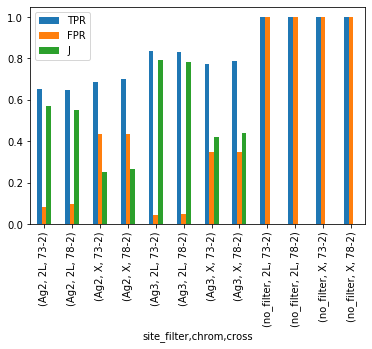

In [37]:
# Select and plot the TPR, FPR and J metrics, for crosses 73-2 and 78-2, and for chroms 2L and X.
example_subset = results_df.set_index(['site_filter', 'chrom', 'cross'])[['TPR', 'FPR', 'J']].sort_index()
example_subset.query('cross == "73-2" or cross == "78-2"').query('chrom == "2L" or chrom == "X"').plot(kind='bar')

### Example 2: Compare metrics between filters across all chromosome arms

One might expect to see the Ag3 site filter perform better for the same ground truths that were used to train its model, namely {18-5, 29-2, 36-9, 42-4, 46-9, 47-6, 78-2, 80-2, K2, K4}, even though we only calculated metrics for sites that were not used in that training.

In [38]:
# Identify the results for ground truths not used in Ag3 training or Ag2 modelling
ag3_biased_crosses = {'18-5', '29-2', '36-9', '42-4', '46-9', '47-6', '78-2', '80-2', 'K2', 'K4'}
ag2_biased_crosses = {'B5', 'K2', 'K4', 'K6'}
biased_results = results_df['cross'].isin(ag3_biased_crosses | ag2_biased_crosses)
unbiased_results = ~biased_results

In [39]:
# Eyeball the number of biased vs unbiased results
print('Potentially biased results:', biased_results.sum())
print('Potentially unbiased results:', unbiased_results.sum())

Potentially biased results: 180
Potentially unbiased results: 45


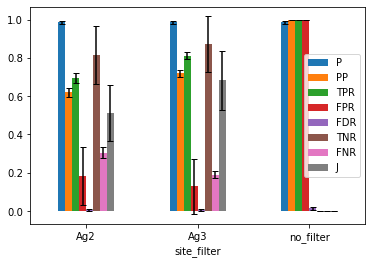

In [40]:
# Plot the mean metric values across unbiased ground truths and all chromosomes, for each of the site filters
unbiased_std = results_df[unbiased_results].groupby(['site_filter']).std()
results_df[unbiased_results].groupby(['site_filter']).mean().plot(kind='bar', rot=0, yerr=unbiased_std, capsize=3)

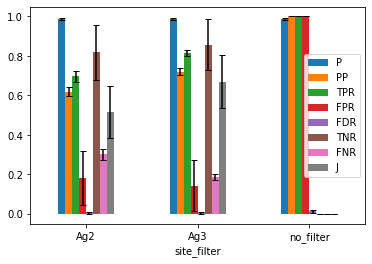

In [41]:
# Compare with potenially biased results
biased_std = results_df[biased_results].groupby(['site_filter']).std()
results_df[biased_results].groupby(['site_filter']).mean().plot(kind='bar', rot=0, yerr=biased_std, capsize=3)